In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, RobustScaler
import requests
from datetime import datetime
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer,OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras import regularizers
import numpy as np

from sklearn.metrics import mean_squared_error

# Preprocess Data

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/courses/HKUST/MSBD5001/project/data/group project/disney_shanghai.csv', parse_dates=['Time'])
test = pd.read_csv('/content/drive/MyDrive/courses/HKUST/MSBD5001/project/data/group project/disney_shanghai_test.csv', 
                   names=['Time', 'Facility ID', 'Name', 'Wait time', 'Ride yype', 
                          'Temperature', 'Max temperature', 'Min temperature', 'Humidity', 
                          'Pressure', 'Wind degree', 'Wind speed', 'Cloud', 'Weather', 
                          'Weather description'],
                   parse_dates=['Time'])

print(train.info())

print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32024 entries, 0 to 32023
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   Name                 32024 non-null  object                               
 1   Ride type            32024 non-null  object                               
 2   Time                 32024 non-null  datetime64[ns, pytz.FixedOffset(480)]
 3   Fastpass-avaliable   32024 non-null  bool                                 
 4   Status               32024 non-null  object                               
 5   Wait time            14621 non-null  float64                              
 6   Weather              32024 non-null  object                               
 7   Weather description  32024 non-null  object                               
 8   Temperature          32024 non-null  float64                              
 9   Max te

show data

In [ ]:

train = train[['Name', 'Time', 'Wait time', 'Weather', 'Temperature', 'Max temperature', 'Min temperature', 'Pressure', 'Humidity', 'Wind degree', 'Wind speed', 'Cloud']]
train.head(2)

,Name,Time,Wait time,Weather,Temperature,Max temperature,Min temperature,Pressure,Humidity,Wind degree,Wind speed,Cloud
0,Camp Discovery,2020-08-31 13:38:47.638019+08:00,0.0,Clouds,33.28,34.0,34.0,1009,66,110.0,5.0,75
1,Challenge Trails at Camp Discovery,2020-08-31 13:38:47.638035+08:00,10.0,Clouds,33.28,34.0,34.0,1009,66,110.0,5.0,75


show test

In [ ]:
test = test[['Name', 'Time', 'Wait time', 'Weather', 'Temperature', 'Max temperature', 'Min temperature', 'Pressure', 'Humidity', 'Wind degree', 'Wind speed', 'Cloud']]
test.head(2)

,Name,Time,Wait time,Weather,Temperature,Max temperature,Min temperature,Pressure,Humidity,Wind degree,Wind speed,Cloud
0,Challenge Trails at Camp Discovery,2020-11-14 10:07:34+00:00,30.0,Clouds,18,18.0,18.0,1026,68,70,3.0,20
1,Vista Trail at Camp Discovery,2020-11-14 10:07:34+00:00,0.0,Clouds,18,18.0,18.0,1026,68,70,3.0,20


## Change name into values

In [ ]:
unique_names = train[['Name']].drop_duplicates()
unique_names['id'] = range(len(unique_names))
train = train.merge(unique_names, on='Name')
unique_names

,Name,id
0,Camp Discovery,0
1,Challenge Trails at Camp Discovery,1
2,Vista Trail at Camp Discovery,2
3,Soaring Over the Horizon,3
4,“Once Upon a Time” Adventure,4
5,Alice in Wonderland Maze,5
6,Frozen: A Sing-Along Celebration,6
7,Hunny Pot Spin,7
8,Peter Pan’s Flight,8
9,Seven Dwarfs Mine Train,9


## Dropna

In [ ]:
train = train.dropna()
test = test.dropna()

## Add busy label

In [ ]:
def is_busy(time: int):
    if time < 30:
        return [1, 0, 0]
    elif time >= 30 and time <= 70:
        return [0, 1, 0]
    else:
        return [0, 0, 1]

## Add weekend and public holiday

In [ ]:
def hour_modify(x: datetime):
    Early_Morning = [4,5,6,7]
    Morning = [8,9,10,11]
    Afternoon = [12,13,14,15]
    Evening = [16,17,18,19]
    Night = [20,21,22,23]
    Late_Night = [0,1,2,3]

    
    if x.hour in Early_Morning:
        return 'Early_Morning'
    elif x.hour in Morning:
        return 'Morning'
    elif x.hour in Afternoon:
        return 'Afternoon'
    elif x.hour in Evening:
        return 'Evening'
    elif x.hour in Night:
        return 'Night'
    else:
        return 'Late_Night'

def add_holiday_and_weekend(df: pd.DataFrame, date_field_str='date') -> pd.DataFrame:
    """
    Add holiday and weekend to the dataset
    """
    new_df = df.copy()
    new_df['IsWeekend'] = new_df[date_field_str].apply(lambda x:0 if x.weekday() in [0,1,2,3,4] else 1)
    new_df['IsHoliday']=new_df[date_field_str].apply(lambda x:1 if (x.date().strftime('%Y-%m-%d') in [
           '2020-01-01', '2020-01-24', '2020-01-24', '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28',
           '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02', '2020-04-04', '2020-05-01',
           '2020-05-02', '2020-05-03', '2020-05-04', '2020-05-05', '2020-06-25', '2020-06-26', '2020-06-27',
           '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-04', '2020-10-05', '2020-10-06', '2020-10-07',
           '2020-10-08', '2020-10-31'])
           or(x.weekday() in[6]) else 0)
    return new_df

convert time zone

In [ ]:
train['Time'] = train['Time'].dt.tz_localize(None)

print(train['Time'])

0       2020-08-31 13:38:47.638019
1       2020-08-31 14:09:47.630487
2       2020-08-31 14:26:10.487907
3       2020-08-31 14:29:48.273505
4       2020-08-31 15:09:11.331162
                   ...            
23808   2020-10-24 15:23:47.123270
23809   2020-10-24 16:25:44.947592
23810   2020-10-24 17:23:16.431926
23816   2020-10-25 10:26:28.625480
23817   2020-10-25 11:24:10.125045
Name: Time, Length: 14621, dtype: datetime64[ns]


In [ ]:
test['Time'] = test['Time'].dt.tz_convert("Asia/Shanghai").dt.tz_localize(None)
print(test['Time'])

0       2020-11-14 18:07:34
1       2020-11-14 18:07:34
2       2020-11-14 18:07:34
3       2020-11-14 18:07:34
4       2020-11-14 18:07:34
                ...        
10340   2020-12-01 19:07:47
10348   2020-12-01 19:07:47
10349   2020-12-01 19:07:47
10350   2020-12-01 19:07:47
10351   2020-12-01 19:07:47
Name: Time, Length: 4016, dtype: datetime64[ns]


Add public holidays

In [ ]:
train = add_holiday_and_weekend(train, 'Time')
test = add_holiday_and_weekend(test, 'Time')

train['Hour modify'] = train['Time'].apply(hour_modify)
test['Hour modify'] = test['Time'].apply(hour_modify)
train['Is busy'] = train['Wait time'].apply(is_busy)

train.head(3)

,Name,Time,Wait time,Weather,Temperature,Max temperature,Min temperature,Pressure,Humidity,Wind degree,Wind speed,Cloud,id,IsWeekend,IsHoliday,Hour modify,Is busy
0,Camp Discovery,2020-08-31 13:38:47.638019,0.0,Clouds,33.28,34.00,34.00,1009,66,110.0,5.0,75,0,0,0,Afternoon,"[1, 0, 0]"
1,Camp Discovery,2020-08-31 14:09:47.630487,0.0,Clouds,33.80,35.56,35.56,1008,70,110.0,5.0,75,0,0,0,Afternoon,"[1, 0, 0]"
2,Camp Discovery,2020-08-31 14:26:10.487907,0.0,Clouds,34.11,35.56,35.56,1008,66,110.0,6.0,75,0,0,0,Afternoon,"[1, 0, 0]"


## Plot Data

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


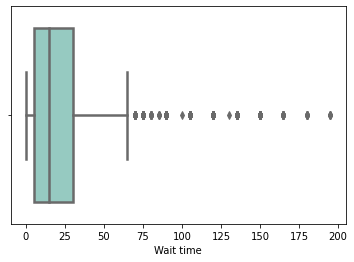

In [ ]:

plt.figure(figsize=(6,4))
sns.boxplot('Wait time',data=train,orient='h',palette="Set3",linewidth=2.5)
plt.show()

In [ ]:
train[['Wait time', 'Temperature', 'Humidity', 'Wind degree', 'Wind speed', 'Cloud']].describe()

,Wait time,Temperature,Humidity,Wind degree,Wind speed,Cloud
count,14621.000000,14621.000000,14621.000000,14621.000000,14621.000000,14621.000000
mean,23.616374,24.423189,64.933862,127.520347,5.352968,45.041174
std,26.388862,4.075267,14.270916,119.544200,1.962247,31.870902
min,0.000000,14.800000,33.000000,0.000000,0.450000,0.000000
25%,5.000000,21.570000,56.000000,30.000000,4.000000,20.000000
50%,15.000000,23.930000,61.000000,70.000000,5.000000,40.000000
75%,30.000000,26.900000,74.000000,180.000000,7.000000,75.000000
max,195.000000,35.050000,100.000000,360.000000,11.000000,100.000000


# Train

In [ ]:
train.columns

Index(['Name', 'Time', 'Wait time', 'Weather', 'Temperature',
       'Max temperature', 'Min temperature', 'Pressure', 'Humidity',
       'Wind degree', 'Wind speed', 'Cloud', 'id', 'IsWeekend', 'IsHoliday',
       'Hour modify', 'Is busy'],
      dtype='object')

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.legend()
  plt.show()



def generate_training_data(data: pd.DataFrame, prediction_label, cat_vars=['id', 'IsWeekend','IsHoliday','Hour modify', 'Weather'], 
                           num_vars=['Temperature', 'Pressure', 'Humidity', 'Cloud', 'Wind degree'], 
                           should_reshape=True, should_split = True):
    x = train.copy()
    y = x[prediction_label].to_list()
    y = np.array(y)

    numeric_transformer=Pipeline(steps=[
    ('scaler', RobustScaler())])
    categorical_transformer=Pipeline(steps=[
    ('oneHot',OneHotEncoder(sparse=False))])

    preprocessor=ColumnTransformer(transformers=[
    ('num',numeric_transformer,num_vars),
    ('cat',categorical_transformer,cat_vars)])

    data_transformed=preprocessor.fit_transform(x)
    if should_split:
        if should_reshape:
            y = y.reshape(-1, 1)
            scaler = MinMaxScaler()
            scaled_y = scaler.fit_transform(y)
            return train_test_split(data_transformed,scaled_y ,test_size=0.02,random_state=42), scaler
        else:
            return train_test_split(data_transformed,y ,test_size=0.02,random_state=42)
    else:
        return data_transformed, y

In [ ]:
data, scaler=generate_training_data(train, 'Wait time')
X_train,X_test,y_train,y_test = data
print(y_train.shape)
print(X_train.shape)

(14328, 1)
(14328, 44)


## Training by using DNN

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu",  
            input_shape=(X_train.shape[1],),),
        layers.Dense(512, activation="relu",  
                     input_shape=(X_train.shape[1],),),
        layers.Dropout(0.5),
        layers.Dense(256, activation="relu",  
                     input_shape=(X_train.shape[1],),),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu",  
                     input_shape=(X_train.shape[1],),),
        layers.Dense(y_train.shape[1] ),
    ]
)

opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='mean_squared_error',
              optimizer=opt, metrics=['mae', 'mse'])

Epoch 1/1000
359/359 [==============================] - 1s 3ms/step - loss: 0.0124 - mae: 0.0775 - mse: 0.0124 - val_loss: 0.0068 - val_mae: 0.0543 - val_mse: 0.0068
Epoch 2/1000
359/359 [==============================] - 1s 3ms/step - loss: 0.0068 - mae: 0.0561 - mse: 0.0068 - val_loss: 0.0061 - val_mae: 0.0495 - val_mse: 0.0061
Epoch 3/1000
359/359 [==============================] - 1s 3ms/step - loss: 0.0058 - mae: 0.0514 - mse: 0.0058 - val_loss: 0.0062 - val_mae: 0.0489 - val_mse: 0.0062
Epoch 4/1000
359/359 [==============================] - 1s 3ms/step - loss: 0.0054 - mae: 0.0487 - mse: 0.0054 - val_loss: 0.0056 - val_mae: 0.0503 - val_mse: 0.0056
Epoch 5/1000
359/359 [==============================] - 1s 3ms/step - loss: 0.0049 - mae: 0.0463 - mse: 0.0049 - val_loss: 0.0048 - val_mae: 0.0469 - val_mse: 0.0048
Epoch 6/1000
359/359 [==============================] - 1s 3ms/step - loss: 0.0046 - mae: 0.0445 - mse: 0.0046 - val_loss: 0.0043 - val_mae: 0.0441 - val_mse: 0.0043
Epoc

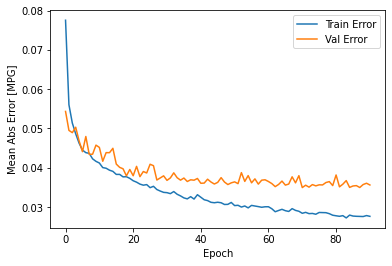

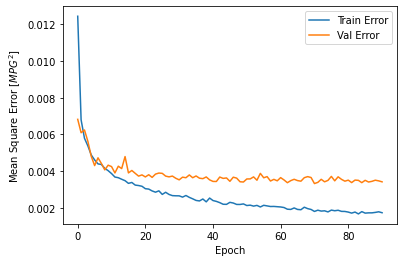

In [ ]:
history = model.fit(X_train, y_train, epochs=1000, callbacks=[early_stop], validation_split=0.2)
plot_history(history)

In [ ]:
y_pred = model.predict(X_test)
err=mean_squared_error(y_pred,y_test)
y_pred_ori = scaler.inverse_transform(y_pred)
y_test_ori = scaler.inverse_transform(y_test)
print(err)
print(y_pred_ori[:10])
print(y_test_ori[:10])


0.0027130306533210595
[[ 8.179743  ]
 [33.693157  ]
 [-0.96347934]
 [18.204435  ]
 [29.795324  ]
 [ 3.690909  ]
 [ 2.5345156 ]
 [46.380207  ]
 [19.597336  ]
 [41.177547  ]]
[[10.]
 [30.]
 [ 0.]
 [15.]
 [15.]
 [ 5.]
 [ 5.]
 [60.]
 [10.]
 [50.]]


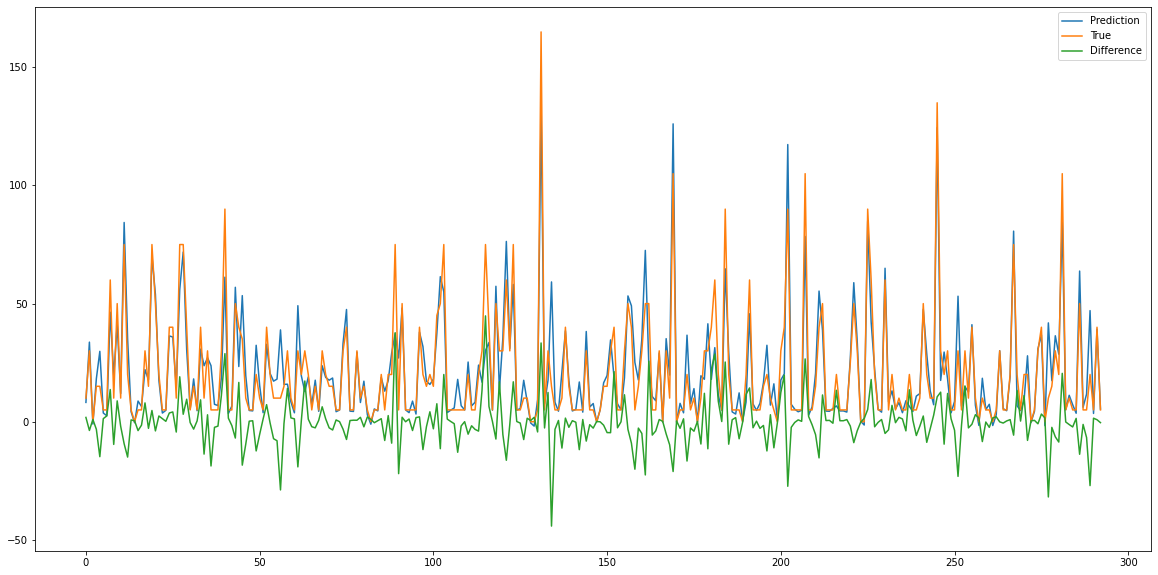

In [ ]:
diff = y_test_ori - y_pred_ori
plt.figure(figsize=(20, 10))
plt.plot(y_pred_ori, label="Prediction")
plt.plot(y_test_ori, label="True")
plt.plot(diff, label="Difference")
plt.legend()

## Training on category

in this case, we will pre-process the wait time into 3 different categories.

- [1, 0, 0]: Wait time < 30 mins

- [0, 1, 0]: Wait time >= 30 and <= 70

- [0, 0, 1]: Else

In [ ]:
cat_vars=['Name', 'IsWeekend','IsHoliday','Hour modify', 'Weather']
num_vars=['Temperature', 'Pressure', 'Humidity', 'Cloud', 'Wind degree', ]

X_train,X_test,y_train,y_test = generate_training_data(train, 'Is busy', cat_vars=cat_vars, num_vars=num_vars, should_reshape=False)
print(y_train.shape)
print(X_train.shape)

(14328, 3)
(14328, 44)


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu",  
            input_shape=(X_train.shape[1],),),
        layers.Dense(512, activation="relu",  
                     input_shape=(X_train.shape[1],),),
        layers.Dropout(0.5),
        layers.Dense(256, activation="relu",  
                     input_shape=(X_train.shape[1],),),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu",  
                     input_shape=(X_train.shape[1],),),
        layers.Dense(y_train.shape[1], activation='softmax' ),
    ]
)

opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              optimizer=opt, metrics=['acc', 'mae', 'mse'])

Epoch 1/1000
359/359 [==============================] - 1s 4ms/step - loss: 0.5546 - acc: 0.7431 - mae: 0.2245 - mse: 0.1133 - val_loss: 0.4317 - val_acc: 0.7994 - val_mae: 0.1869 - val_mse: 0.0900
Epoch 2/1000
359/359 [==============================] - 1s 3ms/step - loss: 0.4437 - acc: 0.7988 - mae: 0.1824 - mse: 0.0921 - val_loss: 0.4212 - val_acc: 0.8022 - val_mae: 0.1744 - val_mse: 0.0887
Epoch 3/1000
359/359 [==============================] - 1s 3ms/step - loss: 0.4240 - acc: 0.8028 - mae: 0.1760 - mse: 0.0882 - val_loss: 0.4124 - val_acc: 0.8043 - val_mae: 0.1713 - val_mse: 0.0864
Epoch 4/1000
359/359 [==============================] - 1s 3ms/step - loss: 0.4135 - acc: 0.8074 - mae: 0.1714 - mse: 0.0863 - val_loss: 0.4075 - val_acc: 0.8105 - val_mae: 0.1645 - val_mse: 0.0852
Epoch 5/1000
359/359 [==============================] - 1s 3ms/step - loss: 0.4013 - acc: 0.8148 - mae: 0.1660 - mse: 0.0833 - val_loss: 0.4032 - val_acc: 0.8109 - val_mae: 0.1682 - val_mse: 0.0848
Epoch 6/10

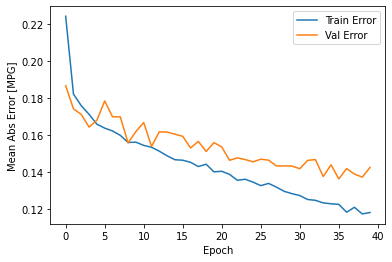

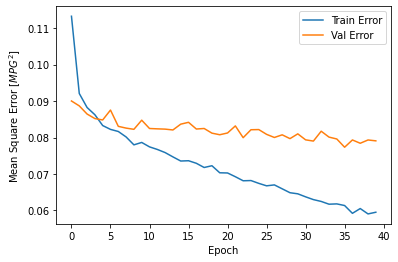

In [ ]:
history = model.fit(X_train, y_train, epochs=1000, callbacks=[early_stop], validation_split=0.2)
plot_history(history)

In [ ]:
y_pred = model.predict(X_test)

def print_acc(pred, true):
    right = 0
    for i in range(len(pred)):
        p = np.argmax(pred[i])
        t = np.argmax(true[i])
        if p == t:
            right += 1

    print(f"acc: {right}/{len(pred)}, {right/len(pred)}")


print_acc(y_pred, y_test)
    

acc: 242/293, 0.825938566552901


## Training by using category

In this example, we will use average-wait-time to compute their waiting time's category

1. If wait-time is less than the average-wait time of that facility, then it is not busy.

2. If wait-time is around average wait-time, then it is in a normal situation

3. If wait-time is above average-wait-time, then it is busy.

In this model, we are basically assume facilities are different. Some will have more popularity than others. And we will use the model to predict whether a model is above its average or not.


In [ ]:
def is_busy_2(row):
    if row[3] < row[1] - 5:
        return [1, 0, 0]
    elif row[3] >= row[1] - 5 and row[3] <= row[1] + 5:
        return [0, 1, 0]
    else:
        return [0, 0, 1]


def calculate_average_wait_time(df: pd.DataFrame)-> pd.DataFrame:
    new_df = df.copy()
    new_df2 = df.copy()
    new_df['tmp_date'] = new_df['Time'].apply(lambda x: x.date())
    new_df = new_df[['tmp_date', 'Wait time', 'Name']]
    new_df = new_df.groupby(['Name']).mean()
    new_df = new_df.rename(columns={'Wait time': 'Average wait time'})

    new_df = new_df.merge(new_df2, on='Name', how='right')
    return new_df


average_sampled_train = calculate_average_wait_time(train)
average_sampled_train['Is busy'] = average_sampled_train.apply(is_busy_2, axis=1)
average_sampled_train.sample(20)

,Name,Average wait time,Time,Wait time,Weather,Temperature,Max temperature,Min temperature,Pressure,Humidity,Wind degree,Wind speed,Cloud,id,IsWeekend,IsHoliday,Hour modify,Is busy
2011,“Once Upon a Time” Adventure,7.246127,2020-09-28 17:19:58.956797,5.0,Clouds,24.47,25.00,25.00,1013,64,90.0,5.0,24,4,0,0,Evening,"[0, 1, 0]"
1764,“Once Upon a Time” Adventure,7.246127,2020-09-04 11:18:13.452477,20.0,Clouds,31.40,32.22,32.22,1013,58,170.0,5.0,84,4,0,0,Morning,"[0, 0, 1]"
4586,Seven Dwarfs Mine Train,52.788310,2020-10-14 13:21:31.350611,30.0,Clear,23.83,26.11,26.11,1023,46,80.0,8.0,0,9,0,0,Afternoon,"[1, 0, 0]"
692,Challenge Trails at Camp Discovery,30.301205,2020-09-21 16:21:10.931996,10.0,Clouds,26.07,26.11,26.11,1015,50,120.0,4.0,100,1,0,0,Evening,"[1, 0, 0]"
4390,Seven Dwarfs Mine Train,52.788310,2020-09-28 14:22:13.132343,20.0,Clouds,26.28,26.67,26.67,1013,57,110.0,6.0,40,9,0,0,Afternoon,"[1, 0, 0]"
6314,Dumbo the Flying Elephant,24.476950,2020-10-05 08:59:42.205314,60.0,Clouds,20.14,21.11,21.11,1020,68,350.0,7.0,75,12,0,1,Morning,"[0, 0, 1]"
4729,The Many Adventures of Winnie the Pooh,21.727129,2020-09-02 13:17:24.463616,25.0,Rain,29.69,32.22,32.22,1001,88,320.0,6.0,40,10,0,0,Afternoon,"[0, 1, 0]"
12363,Rex’s Racer,56.937984,2020-09-11 09:21:31.980597,5.0,Rain,21.62,22.22,22.22,1009,94,150.0,4.0,100,28,0,0,Morning,"[1, 0, 0]"
5825,Voyage to the Crystal Grotto,17.301459,2020-10-12 14:25:12.667032,10.0,Clouds,24.66,25.00,25.00,1016,57,40.0,6.0,20,11,0,0,Afternoon,"[1, 0, 0]"
7677,TRON Lightcycle Power Run – Presented by Chevr...,29.142857,2020-10-16 12:25:27.601525,20.0,Clouds,17.11,17.78,17.78,1023,88,10.0,6.0,75,14,0,0,Afternoon,"[1, 0, 0]"


In [ ]:
cat_vars=['Name', 'IsWeekend','IsHoliday','Hour modify', 'Weather']
num_vars=['Temperature', 'Pressure', 'Humidity', 'Cloud', 'Wind degree', ]

X_train,X_test,y_train,y_test = generate_training_data(average_sampled_train, 'Is busy', cat_vars=cat_vars, num_vars=num_vars, should_reshape=False)

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu",  
            input_shape=(X_train.shape[1],),),
        layers.Dense(512, activation="relu",  
                     input_shape=(X_train.shape[1],),),
        layers.Dropout(0.5),
        layers.Dense(256, activation="relu",  
                     input_shape=(X_train.shape[1],),),
        layers.Dropout(0.5),
        # layers.Dense(512, activation="relu",  
        #              input_shape=(X_train.shape[1],),),
        # layers.Dropout(0.5),
        # layers.Dense(512, activation="relu",  
        #              input_shape=(X_train.shape[1],),),
        # layers.Dropout(0.5),
        # layers.Dense(256, activation="relu",  
        #              input_shape=(X_train.shape[1],),),
        # layers.Dropout(0.5),
        layers.Dense(128, activation="relu",  
                     input_shape=(X_train.shape[1],),),
        layers.Dense(y_train.shape[1], activation='softmax' ),
    ]
)

opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              optimizer=opt, metrics=['acc', 'mae', 'mse'])

Epoch 1/1000
359/359 [==============================] - 1s 4ms/step - loss: 0.5560 - acc: 0.7499 - mae: 0.2245 - mse: 0.1130 - val_loss: 0.4329 - val_acc: 0.8015 - val_mae: 0.1843 - val_mse: 0.0902
Epoch 2/1000
359/359 [==============================] - 1s 3ms/step - loss: 0.4433 - acc: 0.7959 - mae: 0.1820 - mse: 0.0920 - val_loss: 0.4151 - val_acc: 0.8067 - val_mae: 0.1757 - val_mse: 0.0866
Epoch 3/1000
359/359 [==============================] - 1s 3ms/step - loss: 0.4232 - acc: 0.8022 - mae: 0.1752 - mse: 0.0880 - val_loss: 0.4095 - val_acc: 0.8109 - val_mae: 0.1765 - val_mse: 0.0859
Epoch 4/1000
359/359 [==============================] - 1s 3ms/step - loss: 0.4081 - acc: 0.8121 - mae: 0.1698 - mse: 0.0854 - val_loss: 0.4097 - val_acc: 0.8088 - val_mae: 0.1752 - val_mse: 0.0867
Epoch 5/1000
359/359 [==============================] - 1s 3ms/step - loss: 0.4027 - acc: 0.8150 - mae: 0.1678 - mse: 0.0841 - val_loss: 0.4027 - val_acc: 0.8088 - val_mae: 0.1684 - val_mse: 0.0848
Epoch 6/10

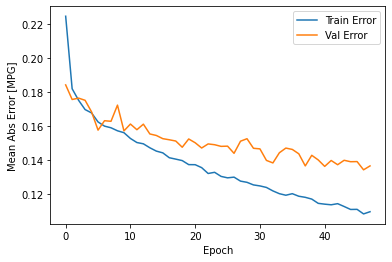

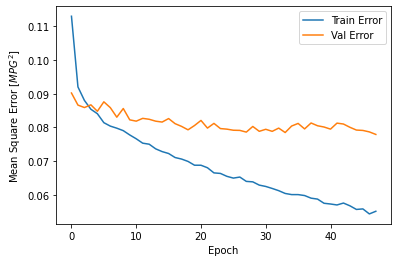

In [ ]:
history = model.fit(X_train, y_train, epochs=1000, callbacks=[early_stop], validation_split=0.2)
plot_history(history)

In [ ]:
y_pred = model.predict(X_test)

print_acc(y_pred, y_test)
    

acc: 243/293, 0.8293515358361775


# LSTM Training

## Window generator

To make a single prediction 24h into the future, given 24h of history you might define a window like this:

![image](https://www.tensorflow.org/tutorials/structured_data/images/raw_window_24h.png)

In [ ]:
class WindowGenerator():
    def __init__(self, input_width, offset, data, train_split):
        self.data = data
        self.input_width = input_width
        self.offset = offset
        self.train_split = train_split
    
    def to_sequences(self):
        """
        Return both data and label
        """
        data_len = len(self.data)
        ret = []
        ret_label = []
        for i in range(data_len - self.offset - self.input_width + 1):
            tmp = self.data[i : i + self.input_width ]
            tmp_label = self.data[i + self.input_width + self.offset - 1]
            ret.append(tmp)
            ret_label.append(tmp_label)

        return np.array(ret), np.array(ret_label)

    def split(self):
        x, y = self.to_sequences()
        num_train = int((1 - self.train_split) * x.shape[0])
        X_train = x[:num_train]
        y_train = y[:num_train]
        X_test = x[num_train:]
        y_test = y[num_train:]
        return X_train, y_train, X_test, y_test

SEQ_LEN = 10
cat_vars=['IsWeekend','IsHoliday']
num_vars=['Temperature', 'Pressure', 'Humidity', 'Cloud', 'Wind degree' ]


In [ ]:
from tensorflow.keras.layers import Bidirectional, Dropout, LSTM, Dense, Activation

## Preprocess data

In [ ]:
average_sampled_train['temp_date'] = average_sampled_train['Time'].apply(lambda x: x.date())
grouped_average = average_sampled_train.groupby('temp_date').mean()
grouped_average = grouped_average[['Temperature', 'Max temperature', 'Min temperature', 'Wind degree', 'Humidity' , 'Wind speed', 'Cloud', 'IsWeekend', 'IsHoliday', "Wait time", "Pressure"]]
grouped_average.columns

Index(['Temperature', 'Max temperature', 'Min temperature', 'Wind degree',
       'Humidity', 'Wind speed', 'Cloud', 'IsWeekend', 'IsHoliday',
       'Wait time', 'Pressure'],
      dtype='object')

In [ ]:
numeric_transformer=Pipeline(steps=[
('scaler', RobustScaler())])
categorical_transformer=Pipeline(steps=[
('oneHot',OneHotEncoder(sparse=False))])

preprocessor=ColumnTransformer(transformers=[
('num',numeric_transformer,num_vars),
('cat',categorical_transformer,cat_vars)])

data_transformed=preprocessor.fit_transform(grouped_average)
print(data_transformed.shape)

(56, 9)


In [ ]:
wg = WindowGenerator(data=data_transformed, input_width=SEQ_LEN, offset=0, train_split=0.1)
wg_2 = WindowGenerator(data=grouped_average['Wait time'].to_numpy(), input_width=SEQ_LEN, offset=0, train_split=0.1)
X_train, _, X_test, _ = wg.split()
_, y_train, _, y_test = wg_2.split()
print(X_train.shape)
print(y_train.shape)

(42, 10, 9)
(42,)


In [ ]:
WINDOW_SIZE = SEQ_LEN

model = keras.Sequential()
# Input layer
model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True), input_shape=(WINDOW_SIZE, X_train.shape[-1])))
"""Bidirectional RNNs allows to train on the sequence data in forward and backward direction."""
model.add(Dropout(rate=0.2))
# 1st Hidden layer
model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences = True)))
model.add(Dropout(rate=0.2))
# 2nd Hidden layer
model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))
# output layer
model.add(Dense(units=1))
model.add(Activation('linear'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_34 (Bidirectio (None, 10, 20)            1600      
_________________________________________________________________
dropout_24 (Dropout)         (None, 10, 20)            0         
_________________________________________________________________
bidirectional_35 (Bidirectio (None, 10, 40)            6560      
_________________________________________________________________
dropout_25 (Dropout)         (None, 10, 40)            0         
_________________________________________________________________
bidirectional_36 (Bidirectio (None, 20)                4080      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 21        
_________________________________________________________________
activation_6 (Activation)    (None, 1)               

In [ ]:
history = model.fit(X_train, y_train, epochs=1000, shuffle=False, validation_split=0.1, callbacks=[early_stop]) 


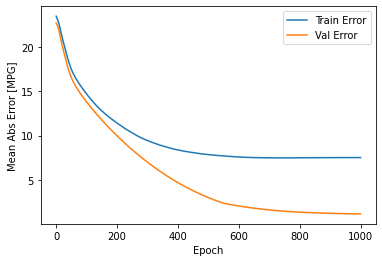

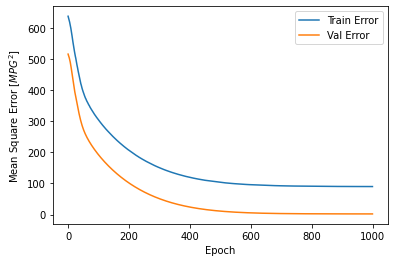

In [ ]:
 plot_history(history)


[15.10416667 25.24390244 20.91836735 37.47126437 19.53846154]


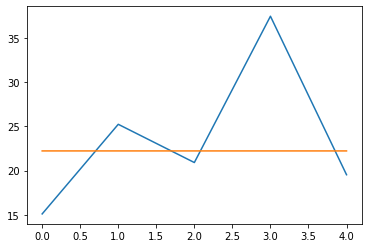

In [ ]:
y_pred = model.predict(X_test)
print()
print(y_test[:10])
plt.plot(y_test)
plt.plot(y_pred.flatten())

# Conclusion

Because we are using averge daily data for LSTM model, we found that it may not be able to predict accurate results based on the current volume of dataset. However, DNN model will provide good prediction for both category results as well as regression results